# Purpose 
This notebook reads in the depth to water table DHSVM output for each of the runs. This output is resampled at higher resolution over the Seattle City Light domain and saved in a netCDF file. Means and std over the Seattle City Light domain are also calculated. The dataset can be visualized in xr vis. The notbook needs to be run for each individual dataset to output the netCDF file.   
 

In [129]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [130]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from rasterio.warp import transform
import pandas as pd
import xarray as xr
from xrviz.dashboard import Dashboard

Read DHSVM depth to water table data and adjust the paths to data as needed

In [131]:
#DHSVM_file_historic = 'Map.Soil.TableDepth.asc.historic'
#DHSVM_file_G_NorESM1_M__rcp85 = 'Map.Soil.TableDepth.asc.bclivlow_G_NorESM1_M__rcp85'
#DHSVM_file_G_NorESM1_M__rcp45 = 'Map.Soil.TableDepth.asc.bclivlow_G_NorESM1_M__rcp45'
#DHSVM_file_G_HadGEM2_ES365__rcp85 = 'Map.Soil.TableDepth.asc.bclivlow_G_HadGEM2_ES365__rcp85'
#DHSVM_file_G_HadGEM2_ES365__rcp45 = 'Map.Soil.TableDepth.asc.bclivlow_G_HadGEM2_ES365__rcp45'
DHSVM_file_G_CNRM_CM5__rcp85 = 'Map.Soil.TableDepth.asc.bclivlow_G_CNRM_CM5__rcp85'
#DHSVM_file_G_CNRM_CM5__rcp45 = 'Map.Soil.TableDepth.asc.bclivlow_G_CNRM_CM5__rcp45'


path_DHSVM = '/Users/carina/Desktop/data/Water_table_skagit/' + DHSVM_file_G_CNRM_CM5__rcp85

values = np.loadtxt(path_DHSVM)


Read dates file. These are going to be used later to attach datetime data in the xarray dataset (saved later as a netCDF file). These are the files that have been generated in Step 1 (see Step 1 Jupyter notebook). These would have to be updated for the new runs.

In [132]:
#dates_historic = 'export_historic_dates'
#dates_G_NorESM1_M__rcp85 = 'export_dates_sat_NorESM1_M_rcp85'
#dates_G_NorESM1_M__rcp45 = 'export_dates_sat_NorESM1_M_rcp45'
#dates_G_HadGEM2_ES365_rcp85 = 'export_dates_sat_HadGEM2_ES365_rcp85'
#dates_G_HadGEM2_ES365__rcp45 = 'export_dates_sat_HadGEM2_ES365_rcp45'
dates_G_CNRM_CM5__rcp85 = 'export_dates_sat_CNRM_CM5_rcp85'
#dates_G_CNRM_CM5__rcp45 = 'export_dates_sat_CNRM_CM5_rcp45'

path_dates = '/Users/carina/Desktop/data/Water_table_skagit/dates_max_sat_sauk_old_files /' + dates_G_CNRM_CM5__rcp85

dates = pd.read_csv(path_dates, sep=" ", header=None)

dates.columns = ["Map", "txt", "number", "date"] 
#dates.columns = ["Index","Map", "txt", "number", "date"] #this works with the new format
dates['date']


0     01/20/2039-21
1     12/03/2039-00
2     06/07/2041-21
3     06/09/2042-09
4     06/11/2043-21
          ...      
57    01/14/2096-18
58    12/21/2096-21
59    12/30/2097-21
60    01/29/2099-21
61    12/30/2099-21
Name: date, Length: 62, dtype: object

In [133]:
#get number of days
num = dates['date'].size
num

62

Read tiff files to get geographic information and resample depth to water table data at higher resolution for the Seattle City Light domain. The files were provided by Ronda Strauch.

In [134]:
# Read the data 
# DHSVM domain 
url_dem = "/Users/carina/Desktop/code/SkagitLandslideHazards/demsrtm150f1.tif"
da = xr.open_rasterio(url_dem)

url_mask = "/Users/carina/Desktop/code/SkagitLandslideHazards/sclmask09_301.tif"
da_mask = xr.open_rasterio(url_mask)
da_mask

<xarray.DataArray (band: 1, y: 2720, x: 2725)>
[7412000 values with dtype=int16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.436e+06 5.436e+06 5.436e+06 5.436e+06 5.436e+06 ...
  * x        (x) float64 5.913e+05 5.914e+05 5.914e+05 5.914e+05 5.914e+05 ...
Attributes:
    transform:   (591315.0, 30.0, 0.0, 5436495.0, 0.0, -30.0)
    crs:         +init=epsg:26910
    res:         (30.0, 30.0)
    is_tiled:    1
    nodatavals:  (-32768.0,)

In [136]:
#get size of y
temp_y = da.y.values
size_y = temp_y.size

Simple visualization of the water table data as a numpy array

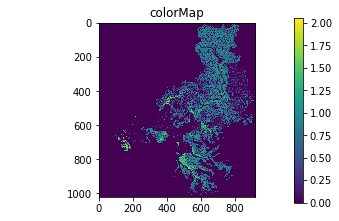

In [128]:
#visualize first day in the dataset
#no_time = values.shape[0]/1020

one_image = values[:size_y]
#second_image = values[1020:2040]

fig = plt.figure(figsize=(6, 3.2))

#plot one image to check 

ax = fig.add_subplot(111)
ax.set_title('colorMap')
plt.imshow(one_image)
ax.set_aspect('equal')

cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)
plt.colorbar(orientation='vertical')
plt.show()

Now, split the big ASCII water table data into separate grids for each day

In [116]:
#split the big concatenated depth to water table data into map/day
list_arrays = np.vsplit(values, num)

all_arrays =  np.asarray(list_arrays)

Create an xrray dataset with water table data. This is at the coarse (150m) DHSVM grid cell resolution. 

In [117]:
#create an xarray dataset conatining depth to water table

ds_wt = xr.Dataset(data_vars = {'wt': (('time', 'y', 'x'), all_arrays)})

Assign x and y data to the water table xarray dataset

In [118]:
#assign coordinates and plot again 
ds_wt['time'] = dates["date"].tolist()
ds_wt['y'] = da.y
ds_wt['x'] = da.x
#ds_wt = ds_wt.set_coords(['time','y', 'x'])


Now we have the DHSVM data in the xarray format with geographic coordinates. Let's plot the first image again.

In [137]:
ds_wt.isel(time=[0]).to_array().plot() 

NameError: name 'ds_wt' is not defined

Interpolate the coarser data to represent the higher resolution (30 m) Seattle City Light domain.

In [120]:
#resample to SCL mask and coordinates 
y1 = da_mask.y
x1 = da_mask.x
dsi = ds_wt.interp(y = y1, x = x1)

Plot the first image of the Seattle City Light domain data at high resolution (30 m)

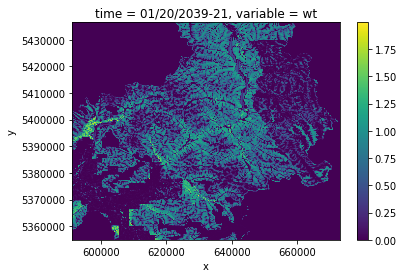

In [121]:
# plot first image of the resampled data
#plot first image, select by index

dsi.isel(time=[0]).to_array().plot() 

Calculate the mean in each grid cell and plot dataset mean of the resampled data. 

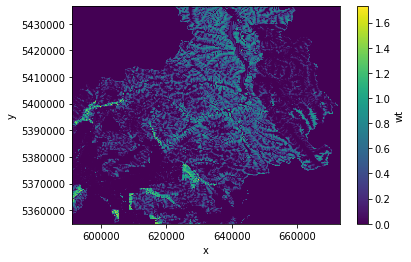

In [122]:
#calculate mean of all grid cells
mean_dtw_scl = dsi.wt.mean("time")
#plot mean
mean_dtw_scl.plot() 

Calculate the standard deviation in each grid cell and plot dataset mean of the resampled data. 

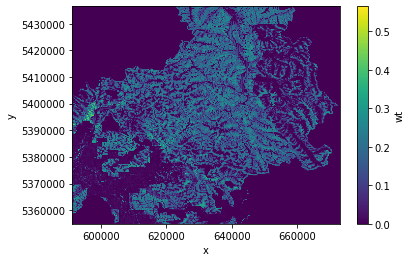

In [123]:
#calculate std of all grid cells
std_dtw_scl = dsi.wt.std("time")
#plot std
std_dtw_scl.plot() 

Visualize the interpolated dataset with xr vis. This wil open another browser window. Visualization with xrvis might not work in Hydroshare

In [126]:
#visualize in xrvis
dashboard = Dashboard(dsi)
dashboard.show()

Save data to netCDF file. The datasets are big (~ 3GB).

In [37]:
#dsi.to_netcdf('dtw_historic_with_dates.nc')

dsi.to_netcdf('dtw_G_CNRM_CM5__rcp85.nc')
#dsi.to_netcdf('dtw_historic_with_dates_netcdf3.nc', format = 'NETCDF3_64BIT')
